In [63]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Data Collection, Preprocessing

##### Load data into tf.Dataset

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset) #length of the dataset

68

In [12]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow()
    print("Image batch size", image_batch.shape)
    print("Label batch", label_batch.numpy())

TypeError: imshow() missing 1 required positional argument: 'X'

#### Data visualization

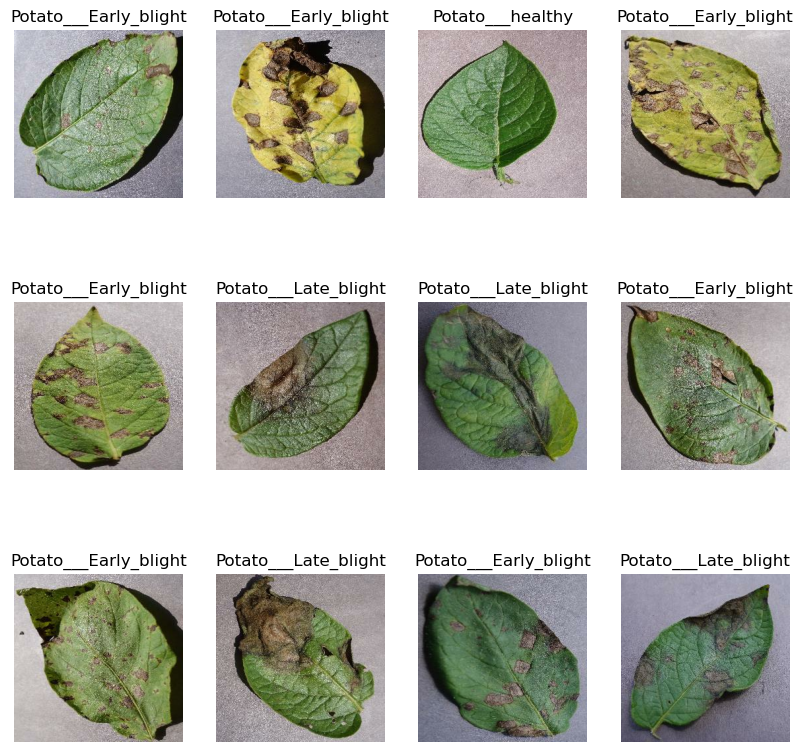

In [13]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
   

#### Train test split

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [14]:
train_size =0.8
len(dataset)* train_size

54.400000000000006

In [15]:
train_ds =  dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54) #arr[:54]
len(test_ds)

14

In [17]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partition_tf(ds, train_split = 0.8 , val_split = 0.1, test_split = 0.1, shuffle= True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset,)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Data Augumentation

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #Resize the images
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Build the model

#### Build and train a CNN model

In [ ]:
# 01. Fisrt define the deep leaning NN architecture 

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'), #normalize the probebilit of the class
])

model.build(input_shape = input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
# 02. Then compile

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'] #Track the training process
)

In [ ]:
# 03. Train the network

In [32]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 99s 2s/step - loss: 0.8689 - accuracy: 0.5278 - val_loss: 0.7624 - val_accuracy: 0.6094
Epoch 2/10
54/54 [==============================] - 83s 2s/step - loss: 0.5825 - accuracy: 0.7436 - val_loss: 0.6865 - val_accuracy: 0.5885
Epoch 3/10
54/54 [==============================] - 82s 2s/step - loss: 0.4095 - accuracy: 0.8328 - val_loss: 0.3532 - val_accuracy: 0.8594
Epoch 4/10
54/54 [==============================] - 82s 2s/step - loss: 0.2500 - accuracy: 0.8993 - val_loss: 0.1379 - val_accuracy: 0.9323
Epoch 5/10
54/54 [==============================] - 82s 2s/step - loss: 0.1726 - accuracy: 0.9317 - val_loss: 0.3848 - val_accuracy: 0.8594
Epoch 6/10
54/54 [==============================] - 81s 2s/step - loss: 0.1617 - accuracy: 0.9334 - val_loss: 0.1463 - val_accuracy: 0.9479
Epoch 7/10
54/54 [==============================] - 81s 1s/step - loss: 0.1668 - accuracy: 0.9369 - val_loss: 0.2488 - val_accuracy: 0.9062
Epoch 8/10
54/54 [==

#### Plot training history on graph

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 358ms/step - loss: 0.2733 - accuracy: 0.9062


In [35]:
scores

[0.273267924785614, 0.90625]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history.history['accuracy']

[0.5277777910232544,
 0.7436342835426331,
 0.8327546119689941,
 0.8993055820465088,
 0.9317129850387573,
 0.9334490895271301,
 0.9369212985038757,
 0.9363425970077515,
 0.9212962985038757,
 0.9479166865348816]

In [42]:
len(history.history['accuracy'])

10

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

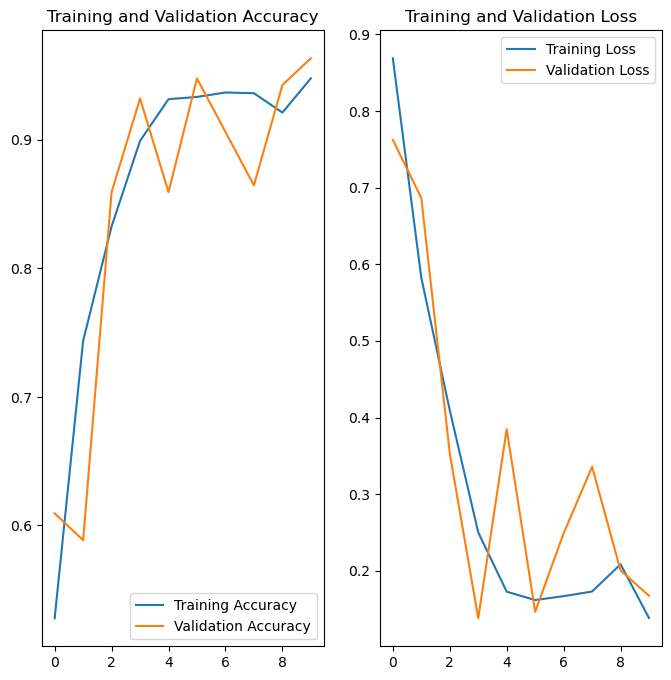

In [46]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')


# Make Predictions / inferences on sample images

First image to predict: 
First image actual label:   Potato___Early_blight
1/1 [==============================] - 0s 392ms/step
Batch Prediction:  Potato___Early_blight


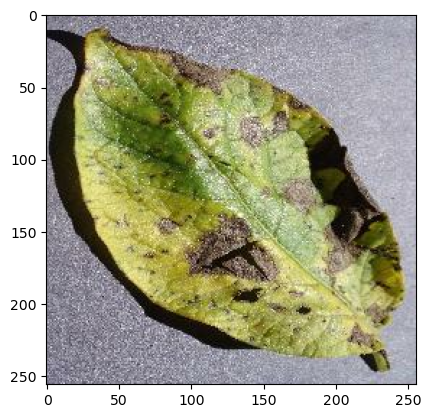

In [71]:
for images_batch, labels_batch in test_ds.take(1):
    #first_image = print(images_batch[0].numpy().astype('uint8'))
    # plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict: ')
    plt.imshow(first_image)
    print('First image actual label:  ' ,class_names[first_label])
    plt.imshow(first_image)
    
    batch_predicion  = model.predict(image_batch)
    print("Batch Prediction: ", class_names[np.argmax(batch_predicion[0])])

In [86]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, cofidence

1/1 [==============================] - 0s 28ms/step


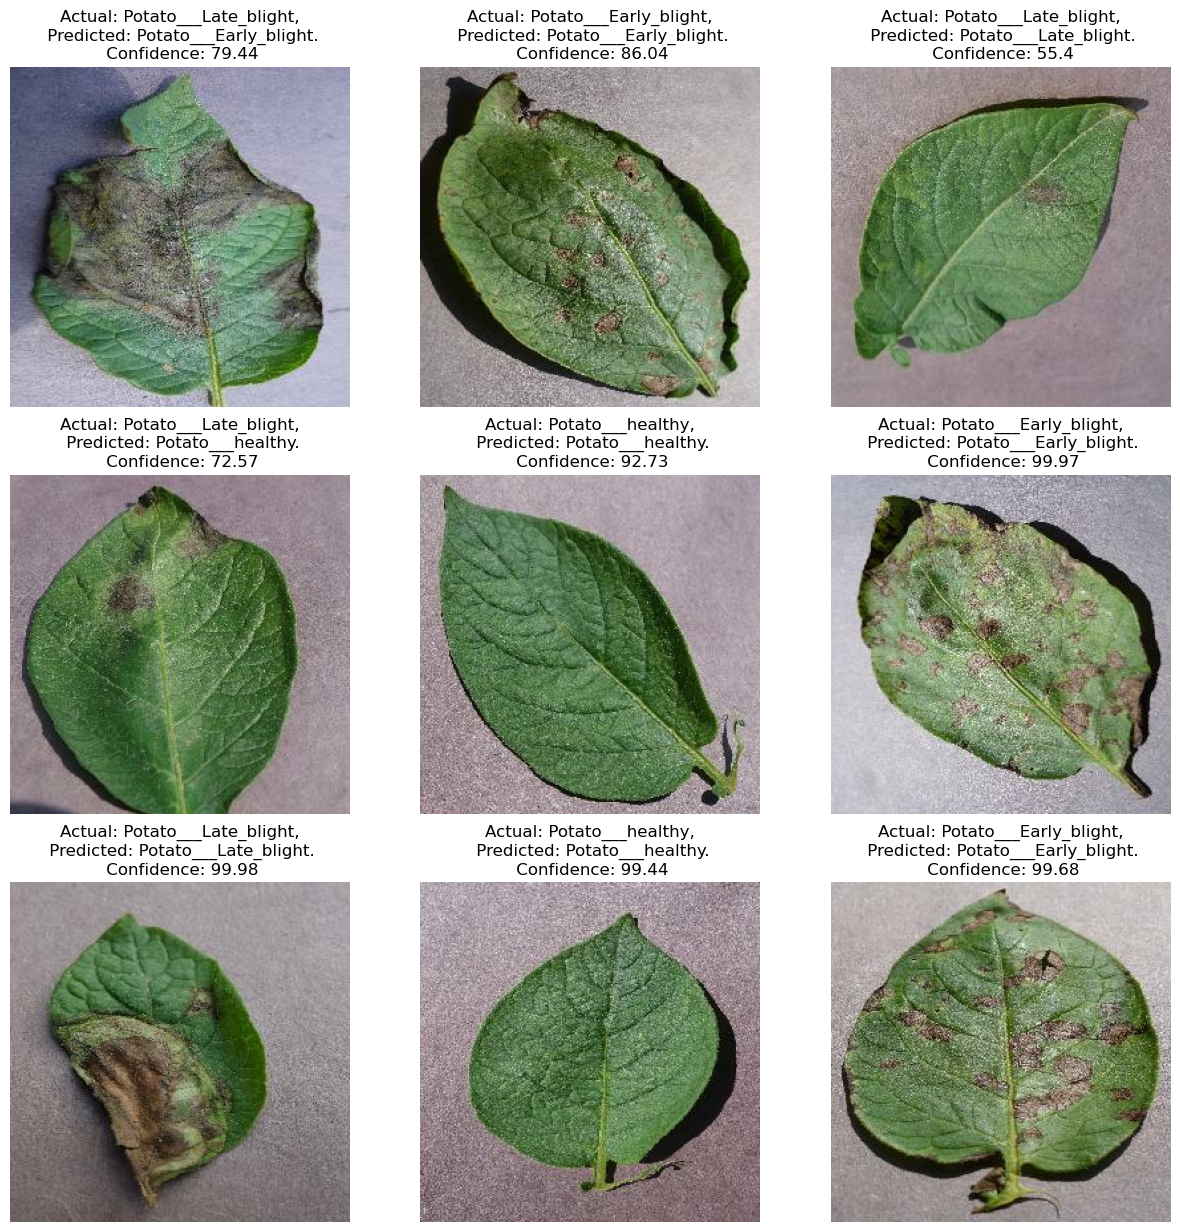

In [88]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):  # Corrected variable name 'lables' to 'labels'
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")  # Corrected 'plot' to 'ax'
        plt.axis("off")
        
plt.show()


# Save the model

In [94]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [89]:
#model_version = 1
#model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
